In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib

In [3]:
# %matplotlib widget
%matplotlib inline

### os 
import os 
import sys

### datetimes 
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from calendar import month_name, month_abbr
import dateparser

### scipy 
import numpy as np 
import pandas as pd
import xarray as xr
from cartopy import crs as ccrs

### plotting 
from matplotlib import pyplot as plt
import palettable

In [4]:
import pathlib

HOME = pathlib.Path.home()
CWD = pathlib.Path.cwd() 

### import local functions for the downloading of the C3S forecasts 

In [5]:
sys.path.append('../..')

In [6]:
from ICU_Water_Watch import geo, C3S, domains, plot, utils

### EEZ shapes 

In [7]:
dpath_shapes = HOME.joinpath('operational/ICU/development/hotspots/data/shapefiles')

In [8]:
EEZs, merged_EEZs = geo.get_EEZs(dpath_shapes)

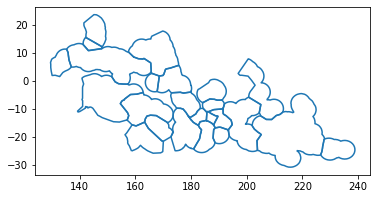

In [9]:
EEZs.boundary.plot(); 

### year and month (initial month of the forecast)

In [10]:
date = 'this month'

In [11]:
year = dateparser.parse(date).year

In [12]:
month = dateparser.parse(date).month

In [13]:
print(f"{year} - {month}")

2021 - 11


### read the probabilistic forecasts from the GCMs now 

### provider 

In [14]:
provider = 'CDS'

#### list of GCMs to inlude 

In [15]:
list_GCMs = ['ECMWF','UKMO','METEO_FRANCE','CMCC','DWD', 'NCEP', 'JMA', 'ECCC_CanCM4i', 'ECCC_GEM_NEMO']

#### period (`monthly` or `seasonal`)

In [16]:
period = 'monthly'
# period = 'seasonal'

In [17]:
if period == 'seasonal': 
    nsteps = 3
    first_step = 3
elif period == 'monthly': 
    nsteps = 5
    first_step = 1

#### quantiles (`tercile`, `decile`, `percentile`, with the latest including categories defined by quantile 0.02 (2%) and then 0.05 to 0.95 with 0.05 increment)

In [18]:
quantile = 'decile'

### variable 

In [19]:
varname = 'precip'

### domain 

In [20]:
domains.domains

{'Tropical_Pacific': [140, 220, -25, 25],
 'SW_Pacific': [172.5, 190, -22.5, -12],
 'Fiji': [175, 183, -21, -15],
 'NZ': [161, 181, -50, -30],
 'Pacific': [140, 240, -50, 25],
 'C3S_download': [100, 240, -50, 30],
 'Water_Watch': [120, 240, -35, 25]}

In [21]:
domain = 'Water_Watch'

### paths to the realtime forecasts

In [22]:
dpath_forecasts = CWD.parents[1].joinpath("outputs/C3S")

In [23]:
lfiles = list(dpath_forecasts.glob(f"{period}_{quantile}s_probabilities_from_{year}-{str(month).zfill(2)}_*.netcdf"))

### checks the files names 

In [24]:
[f.name for f in lfiles]

['monthly_deciles_probabilities_from_2021-11_CMCC.netcdf',
 'monthly_deciles_probabilities_from_2021-11_DWD.netcdf',
 'monthly_deciles_probabilities_from_2021-11_ECCC_GEM_NEMO.netcdf',
 'monthly_deciles_probabilities_from_2021-11_JMA.netcdf',
 'monthly_deciles_probabilities_from_2021-11_ECMWF.netcdf',
 'monthly_deciles_probabilities_from_2021-11_NCEP.netcdf',
 'monthly_deciles_probabilities_from_2021-11_METEO_FRANCE.netcdf',
 'monthly_deciles_probabilities_from_2021-11_UKMO.netcdf',
 'monthly_deciles_probabilities_from_2021-11_ECCC_CanCM4i.netcdf']

### open the multiple files dataset, concatenate along the "GCM" dimension 

In [25]:
probs = xr.open_mfdataset(lfiles, concat_dim='GCM', combine='nested', engine='netcdf4') 

In [26]:
probs

,Array,Chunk
Bytes,33.65 MiB,3.74 MiB
Shape,"(9, 10, 1, 5, 81, 121)","(1, 10, 1, 5, 81, 121)"
Count,27 Tasks,9 Chunks
Type,float64,numpy.ndarray


### interpolate

In [27]:
probs = utils.interp(probs, interp_factor=6)

In [28]:
probs

,Array,Chunk
Bytes,1.18 GiB,134.60 MiB
Shape,"(9, 10, 1, 5, 486, 726)","(1, 10, 1, 5, 486, 726)"
Count,71 Tasks,9 Chunks
Type,float64,numpy.ndarray


In [29]:
probs = probs.mean('GCM')

### make sure the probabilities sum to 100 over the decile dimension 

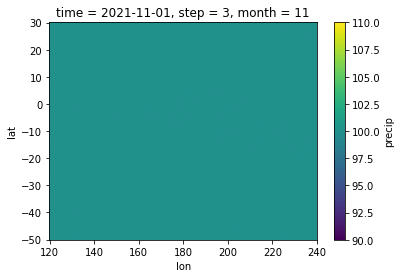

In [30]:
probs.sum('decile').squeeze().sel(step=3)['precip'].plot()

### Now calculates the cumulative probabilities over the decile dimension 

In [31]:
cum_probs = probs.cumsum('decile', keep_attrs=True)

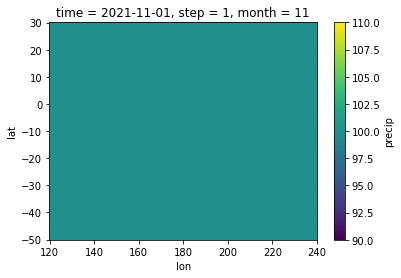

In [32]:
cum_probs.isel(decile=-1).sel(step=first_step).squeeze()['precip'].plot()

### recode the decile values, so they go from 1 to 10 instead of 0 to 9 

In [33]:
cum_probs.decile

<xarray.DataArray 'decile' (decile: 10)>
array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Coordinates:
    month    int64 11
Dimensions without coordinates: decile

In [34]:
cum_probs['decile'] = cum_probs['decile'] + 1

In [35]:
cum_probs.decile

<xarray.DataArray 'decile' (decile: 10)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])
Coordinates:
    month    int64 11
  * decile   (decile) int64 1 2 3 4 5 6 7 8 9 10

#### selects probabilities greater or equal than 50% 

In [36]:
cum_probs = cum_probs.where(cum_probs['precip'] >= 50)

### quick plot of the minimum decile value for the cumulative decile probabilities reaching 50% 

Text(0.5, 1.0, '')

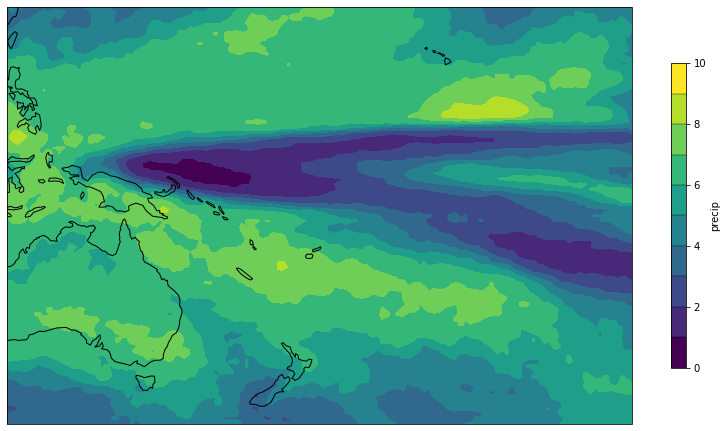

In [37]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(14,8))

cum_probs.idxmin('decile').squeeze().sel(step=first_step)['precip'].plot.contourf(ax=ax, levels=np.arange(0, 11), transform=ccrs.PlateCarree(), \
                                                                   cbar_kwargs={'shrink':0.7, 'boundaries':np.arange(11), 'drawedges':True})
ax.coastlines()

ax.set_title('')

### Now starts the prototype plotting 

In [38]:
thresholds = np.arange(0.5, 10.5 + 1, 1)

In [39]:
thresholds

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5])

In [40]:
ticks_marks = np.diff(np.array(thresholds)) / 2.

ticks = [thresholds[i] + ticks_marks[i] for i in range(len(thresholds) - 1)]

In [41]:
ticks

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

In [42]:
hexes = ['#003c30', '#01665e', '#35978f', '#80cdc1', '#c7eae5', '#f6e8c3', '#dfc27d', '#bf812d', '#8c510a', '#543005']

In [43]:
hexes.reverse()

In [44]:
cbar_ticklabels = ['>90%', '80-90%', '70-80%', '60-70%', '50-60%', '40-50%', '30-40%', '20-30%', '10-20%', '< 10%']

In [45]:
cbar_ticklabels.reverse()

In [46]:
cbar_ticklabels

['< 10%',
 '10-20%',
 '20-30%',
 '30-40%',
 '40-50%',
 '50-60%',
 '60-70%',
 '70-80%',
 '80-90%',
 '>90%']

In [47]:
import matplotlib

In [48]:
cmap = matplotlib.colors.ListedColormap(hexes, name='decile')

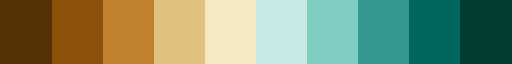

In [49]:
cmap

In [50]:
decile_map = cum_probs.idxmin('decile').squeeze().sel(step=first_step)

In [51]:
merged_EEZs

,index,geometry
0,EEZ,"POLYGON ((188.63281 -22.23893, 188.62887 -22.2..."


In [52]:
decile_map = geo.make_mask_from_gpd(decile_map, merged_EEZs, subset=False, insert=True)

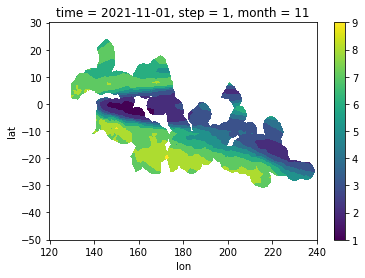

In [53]:
(decile_map['precip'] * decile_map['mask']).plot()

In [54]:
month_name = list(month_name)

In [55]:
month_name += month_name[1:]

In [56]:
period

'monthly'

In [57]:
if period == 'monthly': 
    period_label = month_name[month + 1]
elif period == 'seasonal': 
    period_label = month_name[month + 1] + ' through ' + month_name[month + 3]

In [58]:
period_label

'December'

In [59]:
domains.domains[domain][:2]

[120, 240]

In [60]:
# decile_map = decile_map.sel(lon=slice(*domains.domains[domain][:2]), lat=slice(*domains.domains[domain][2:]))

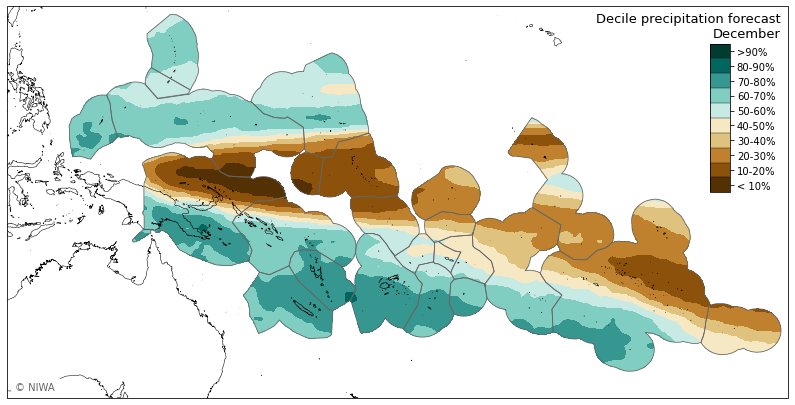

In [61]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)), figsize=(14,8))

ff = (decile_map['precip'] * decile_map['mask']).plot.contourf(ax=ax, levels=thresholds, cmap=cmap, transform=ccrs.PlateCarree(), add_colorbar=False)

ax.coastlines(resolution='10m', lw=0.5)

ax.set_title('')

cbar_kwargs={'shrink':0.5, 'pad':0.01, 'extend':'neither', 'drawedges':True, 'ticks':ticks, 'aspect':15}

cbar_ax = ax.axes.inset_axes([0.9, 0.525, 0.025, 0.38])

cb = plt.colorbar(ff, cax=cbar_ax, **cbar_kwargs)

cb.ax.minorticks_off()

cbar_ax.set_yticklabels(cbar_ticklabels)

plot.add_geom(ax, geoms=EEZs)

title = f"Decile precipitation forecast\n{period_label}"

ax.text(0.99, 0.95, title, fontsize=13, fontdict={'color':'k'}, bbox=dict(facecolor='w', edgecolor='w'), horizontalalignment='right', verticalalignment='center', transform=ax.transAxes)

ax.text(0.01, 0.02, u'\u00A9'+" NIWA", transform=ax.transAxes, bbox=dict(facecolor='w', edgecolor='w'), fontdict=dict(color='0.4'))

ax.set_extent([120, 240, -35, 25], crs = ccrs.PlateCarree())

In [62]:
f.savefig(f'/home/nicolasf/Desktop/decile_forecast_prototype_{period}_{year}_{month:02d}.png', dpi=200, facecolor='w', bbox_inches='tight')